In [1]:
from insilico_Exp_torch import TorchScorer
from layer_hook_utils import featureFetcher, get_module_names, get_layer_names, register_hook_by_module_names
from os.path import join
import numpy as np
import matplotlib.pylab as plt
# from tqdm import tqdm
import torch
from imageio import imread
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import Dataset, DataLoader  #, ImageDataset
from torchvision.transforms import Compose, Resize, Normalize, ToPILImage, ToTensor
from NN_PC_visualize.NN_PC_lib import record_dataset
from dataset_utils import create_imagenet_valid_dataset
import torchvision.models as models
from AdeptOptimizer_Single import AdeptOptimizer_Single 
from AdeptOptimizer_Batch import AdeptOptimizer_Batch 
from RandomOptimizer_Batch import RandomOptimizer_Batch

In [2]:
import sys
from sys import path
print(sys.path)

['/Users/macbook/Desktop/Research/Harvard_Group/Discrete_Image_Recommender', '/Users/macbook/opt/anaconda3/lib/python39.zip', '/Users/macbook/opt/anaconda3/lib/python3.9', '/Users/macbook/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/macbook/opt/anaconda3/lib/python3.9/site-packages', '/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg', '/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/Users/macbook/.ipython']


In [3]:
RGB_mean = torch.tensor([0.485, 0.456, 0.406]) #.view(1,-1,1,1).cuda()
RGB_std  = torch.tensor([0.229, 0.224, 0.225]) #.view(1,-1,1,1).cuda()
preprocess = Compose([ToTensor(),
                      Resize((224, 224)),
                      Normalize(RGB_mean, RGB_std),
                      ])
dataset = ImageFolder(r"/Users/macbook/Desktop/Research/Harvard_Group/Visual_Neuro_InSilico_Exp/ImageNet_data/imagenet_50K_val", transform=preprocess)

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /Users/macbook/Desktop/Research/Harvard_Group/Visual_Neuro_InSilico_Exp/ImageNet_data/imagenet_50K_val
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
           )

In [31]:
#model = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
#                       'resnet50_swsl')
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Li/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [42]:
### ResNet 50
#feattsr = record_dataset(model, [".layer2.Bottleneck3", ".layer3.Bottleneck5",
#                                 ".layer4.Bottleneck0", ".layer4.Bottleneck2", ],
#                         dataset, return_input=False, batch_size=125, num_workers=8)
# num_workers=8, 3:20:54, 400it
# feattsr is a dictionary where each key is a target layer whose value is the corresponding activations in the layer

### Pretrained AlexNet
embeddings = record_dataset(model, [".features.Conv2d6", ".features.Conv2d8", 
                                     ".features.Conv2d10", ".classifier.Linear1",
                                     ".classifier.Linear4"], dataset, return_input=False, batch_size=125, num_workers=8)

400it [10:41,  1.60s/it]


FeatureFetcher hooks all freed


In [43]:
savedir = r"C:\Users\Li\Research\Harvard_Group\Discrete_Image_Recommender\recordings"
torch.save(embeddings, join(savedir, "alexnet_pretrained_activations.pt"))

In [5]:
embeddings = torch.load(r"/Users/macbook/Desktop/Research/Harvard_Group/Discrete_Image_Recommender/recordings/alexnet_pretrained_activations.pt")

In [6]:
target_layers = [".features.Conv2d6", ".features.Conv2d8", ".features.Conv2d10", ".classifier.Linear1", ".classifier.Linear4"]
for layer in target_layers:
    print(embeddings[layer].shape)

torch.Size([50000, 384])
torch.Size([50000, 256])
torch.Size([50000, 256])
torch.Size([50000, 4096])
torch.Size([50000, 4096])


In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3000, shuffle=False)
images, labels = next(iter(dataloader))
#fig, axs = plt.subplots(4, 5, figsize = (50, 50))
#for i in range(4):
#    for j in range(5):
#        axs[i][j].imshow(images[4*i + j].permute(1, 2, 0))


In [11]:
images_pool = images

NameError: name 'images' is not defined

In [41]:
embeddings = torch.load(r"/Users/macbook/Desktop/Research/Harvard_Group/Discrete_Image_Recommender/recordings/alexnet_pretrained_activations.pt")
embeddings_pool = embeddings[".features.Conv2d10"][:1000]

In [36]:
import sklearn.metrics.pairwise
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import euclidean_distances

In [37]:
brain_activations = torch.load(r"/Users/macbook/Desktop/Research/Harvard_Group/Discrete_Image_Recommender/recordings/resnet50_swsl_INvalid_feattsrs_50K.pt")

In [38]:
brain_rewards = brain_activations[".layer3.Bottleneck5"]
print(brain_rewards.shape)

torch.Size([50000, 1024])


In [17]:
class DiscreteOptimizer_Adept:
    def __init__(self, images_pool, embeddings_pool, brain_rewards, N_init=50, h=200, shuffle=True):
        self.num_stimuli = images_pool.shape[0]
        self.embed_dim = embeddings_pool.shape[1]
        self.kernel_mat = rbf_kernel(embeddings_pool, gamma=1/(h*h))
        self.reward_diffs = np.zeros((N_init, N_init))
        if shuffle:
            self.chosen_indices = np.random.choice(self.num_stimuli, N_init)
            self.reward_diffs += euclidean_distances(np.take(brain_rewards, self.chosen_indices, axis=0))
        else:    
            self.reward_diffs += euclidean_distances(brain_rewards[:N_init])
            self.chosen_indices = np.arange(N_init)
        
        self.reward_norms = np.linalg.norm(brain_rewards, axis=1)
        
    def update_and_propose(self):
        candidates = np.zeros(self.num_stimuli)
        for i in range(self.num_stimuli):
            if i not in self.chosen_indices:
                num_seen_stimuli = len(self.chosen_indices)
                kernel_embedding = self.kernel_mat[self.chosen_indices][:, i] / np.sum(self.kernel_mat[self.chosen_indices][:, i])
                norm = np.dot(kernel_embedding, np.take(self.reward_norms, self.chosen_indices))
                avg_dist = np.mean(np.matmul(kernel_embedding.T, self.reward_diffs))
                candidates[i] = norm + avg_dist
                
        best_candidate = np.argmax(candidates)
        dist = euclidean_distances(np.take(brain_rewards, self.chosen_indices, axis=0), brain_rewards[best_candidate].reshape(1, -1))
        self.reward_diffs = np.hstack((self.reward_diffs, euclidean_distances(np.take(brain_rewards, self.chosen_indices, axis=0), brain_rewards[best_candidate].reshape(1, -1))))
        self.chosen_indices = np.append(self.chosen_indices, best_candidate)
        self.reward_diffs = np.vstack((self.reward_diffs, np.transpose(euclidean_distances(np.take(brain_rewards, self.chosen_indices, axis=0), brain_rewards[best_candidate].reshape(1, -1)))))
        print("Number of proposed images: ", len(self.chosen_indices))
        return images_pool[best_candidate]

In [16]:
adeptOpt = DiscreteOptimizer_Adept(images_pool, embeddings_pool, brain_rewards, shuffle=True)

In [40]:
#for i in range(1000):
#    img = adeptOpt.update_and_propose()

#plt.imshow(img.permute(1, 2, 0))
#print(adeptOpt.chosen_indices)

In [37]:
# mean responses from Adept and random chosen images:
adept_indices = adeptOpt.chosen_indices
adept_brain_responses = np.array(np.take(brain_rewards, adept_indices, axis=0))
mean_adept_responses = np.mean(adept_brain_responses, axis=0)

random_indices = np.random.choice(range(2000), 1050)
random_brain_responses = np.array(np.take(brain_rewards, random_indices, axis=0))
mean_random_responses = np.mean(random_brain_responses, axis=0)

mean_diffs = mean_adept_responses - mean_random_responses
mean_ratios = mean_adept_responses / mean_random_responses
print(mean_ratios)
print(len(mean_ratios[mean_ratios < 1]))

[1.201909   1.349015   1.2965591  ... 1.5154306  0.8248516  0.99712425]
382


In [34]:
# scatter of eigenvalues
#from sklearn.decomposition import PCA
#pca_adept = PCA()
#pca_adept.fit(adept_brain_responses)
#print(pca_adept.explained_variance_ratio_)
#pca_random = PCA()
#pca_random.fit(random_brain_responses)
#print(pca_random.explained_variance_ratio_)

In [30]:
#x = np.arange(100)
#y = pca_adept.explained_variance_ratio_[:100]
#plt.plot(x, y)

In [31]:
#y1 = pca_random.explained_variance_ratio_[:100]
#plt.plot(x, y1)

In [33]:
#adeptBatchOpt = AdeptOptimizer_Batch(embeddings_pool, brain_rewards, shuffle=True, alpha=2)

In [32]:
#for i in range(20):
#    best_candidates = adeptBatchOpt.propose_batch()
#    image_scores = adeptBatchOpt.evaluate_and_update_batch(best_candidates)
#    print(best_candidates)

In [18]:
def analyze_performance_magnitude(adeptOpt, randomOpt, num_iterations, propose_mode):
    fig, axs = plt.subplots(1, 4, figsize=(80, 20))
    
    # Batch Mean
    adept_mean = np.empty(num_iterations+1)
    random_mean = np.empty(num_iterations+1)
    adept_mean[0] = np.mean(np.array(np.take(adeptOpt.brain_rewards_noisy, adeptOpt.init_indices, axis=0)))
    random_mean[0] = np.mean(np.array(np.take(randomOpt.brain_rewards_noisy, randomOpt.init_indices, axis=0)))
    
    adept_historical_max = np.empty(num_iterations+1)
    random_historical_max = np.empty(num_iterations+1)
    adept_historical_max[0] = np.mean(np.array(adeptOpt.best_reward))
    random_historical_max[0] = np.mean(np.array(randomOpt.best_reward))
    
    adept_sample = np.empty(num_iterations+1)
    random_sample = np.empty(num_iterations+1)
    _, adept_init_reward = adeptOpt.propose_one(adeptOpt.init_indices, propose_mode)
    _, random_init_reward = randomOpt.propose_one(randomOpt.init_indices, 'naive random')
    adept_sample[0] = np.mean(np.array(adept_init_reward))
    random_sample[0] = np.mean(np.array(random_init_reward))
    
    
    for i in range(1, num_iterations+1):
        print("# Iterations:", i)
        adept_candidates = adeptOpt.propose_batch()
        adept_responses = adeptOpt.evaluate_and_update_batch(adept_candidates)
        adept_mean[i] = np.mean(np.array(adept_responses))
        adept_historical_max[i] = np.mean(np.array(adeptOpt.best_reward))
        _, adept_sample_reward = adeptOpt.propose_one(adept_candidates, propose_mode)
        adept_sample[i] = np.mean(np.array(adept_sample_reward))
        
        random_candidates = randomOpt.propose_batch()
        random_responses = randomOpt.evaluate(random_candidates)
        random_mean[i] = np.mean(np.array(random_responses))
        random_historical_max[i] = np.mean(np.array(randomOpt.best_reward))
        _, random_sample_reward = randomOpt.propose_one(random_candidates, 'naive random')
        random_sample[i] = np.mean(np.array(random_sample_reward))
    x = np.arange(num_iterations+1)
    
    # Batch mean
    axs[0].plot(x, adept_mean)
    axs[0].plot(x, random_mean)
    
    # Historical max
    axs[1].plot(x, adept_historical_max)
    axs[1].plot(x, random_historical_max)
    
    # Random sample from proposed batch
    axs[2].plot(x, adept_sample)
    axs[2].plot(x, random_sample)
    

Initial Images #:  [663 685 357 641 606 982 113 378  39  11 676 933 941 191   4 350 216 714
  76 675  84 565 632 356 880 748 691  51  92 539 726 250 923 245 397 865
 350 353 580 307 250 849 147 981 399  98 864 853 136 639]
# Iterations: 1
# Iterations: 2
# Iterations: 3
# Iterations: 4
# Iterations: 5
# Iterations: 6
# Iterations: 7
# Iterations: 8
# Iterations: 9
# Iterations: 10
# Iterations: 11
# Iterations: 12
# Iterations: 13
# Iterations: 14
# Iterations: 15
# Iterations: 16
# Iterations: 17
# Iterations: 18
# Iterations: 19
# Iterations: 20
# Iterations: 21
# Iterations: 22
# Iterations: 23
# Iterations: 24
# Iterations: 25
# Iterations: 26
# Iterations: 27
# Iterations: 28
# Iterations: 29
# Iterations: 30
# Iterations: 31
# Iterations: 32
# Iterations: 33
# Iterations: 34
# Iterations: 35
# Iterations: 36
# Iterations: 37
# Iterations: 38
# Iterations: 39
# Iterations: 40
# Iterations: 41
# Iterations: 42
# Iterations: 43
# Iterations: 44
# Iterations: 45
# Iterations: 46
# It

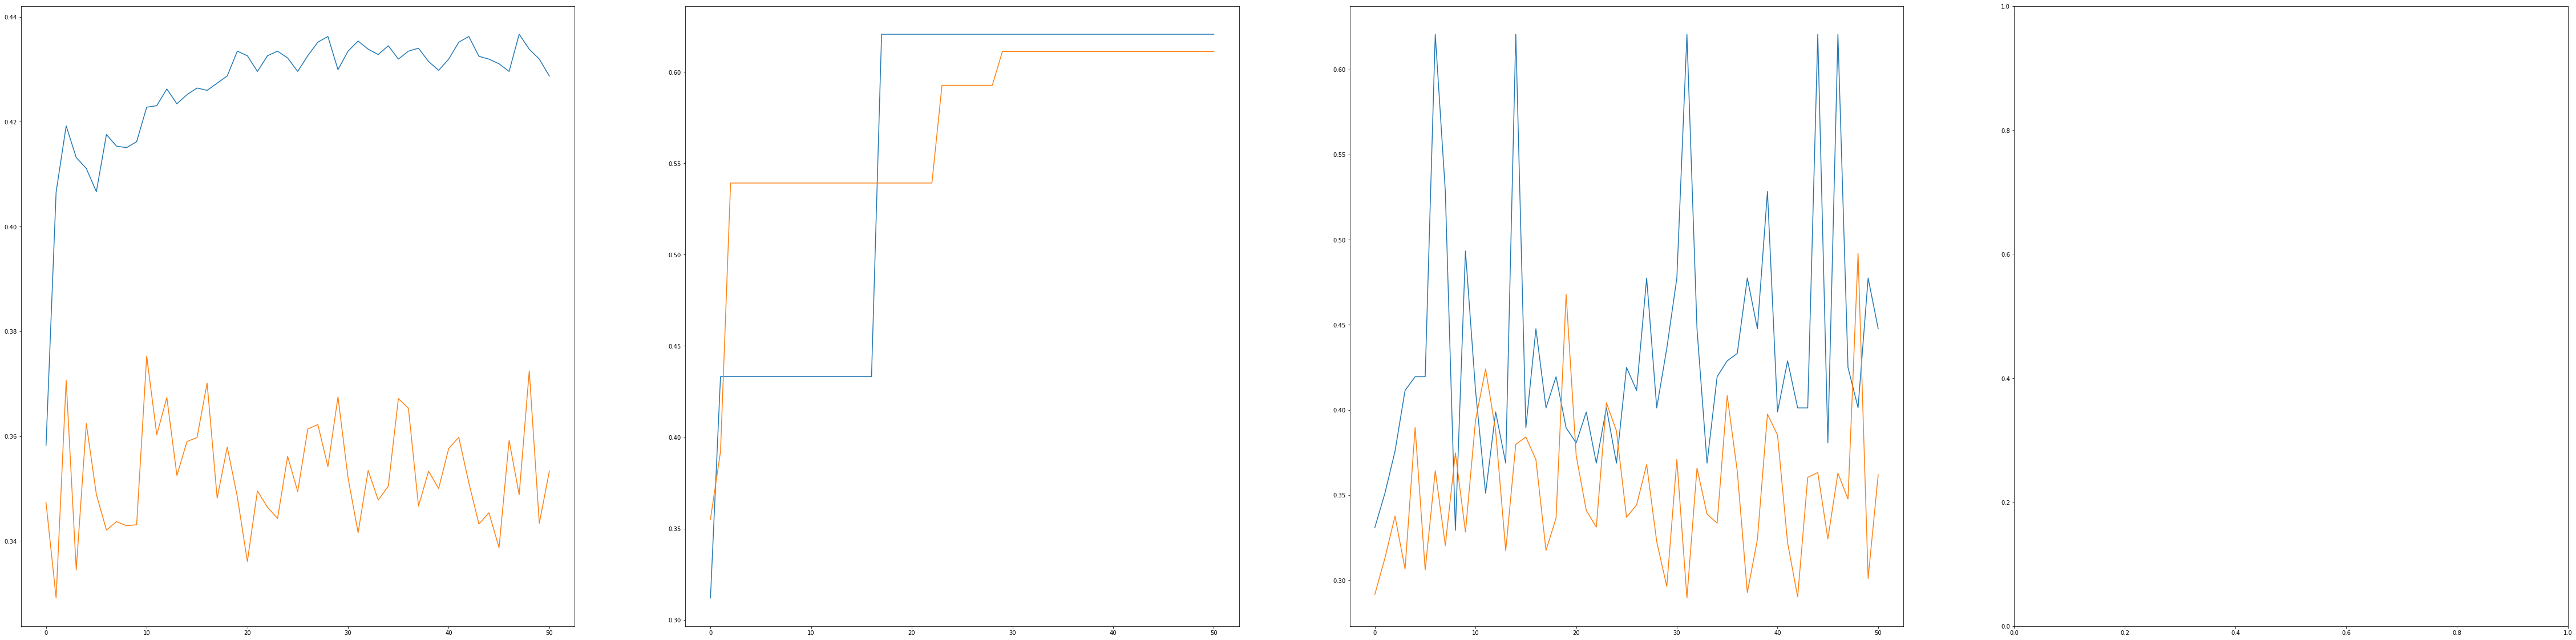

In [42]:
adeptOpt = AdeptOptimizer_Batch(embeddings_pool, brain_rewards, shuffle=True, batch_size=20, alpha=0)
randomOpt = RandomOptimizer_Batch(brain_rewards, 1000, batch_size=20)
analyze_performance_magnitude(adeptOpt, randomOpt, 50, 'naive random')

Initial Images #:  [1552   67    9 1520  532 1126 1436  969  387  930 1653 1308  646 1306
  978   22  307 1501  153  326 1442 1519 1856 1295   65  522  285 1051
 1551  318 1955 1212  819  510  583  608 1515 1176 1078  667  709  781
  207  608 1730 1634 1543 1509  603 1478]
# Iterations: 1
# Iterations: 2
# Iterations: 3
# Iterations: 4
# Iterations: 5
# Iterations: 6
# Iterations: 7
# Iterations: 8
# Iterations: 9
# Iterations: 10
# Iterations: 11
# Iterations: 12
# Iterations: 13
# Iterations: 14
# Iterations: 15
# Iterations: 16
# Iterations: 17
# Iterations: 18
# Iterations: 19
# Iterations: 20
# Iterations: 21
# Iterations: 22
# Iterations: 23
# Iterations: 24
# Iterations: 25
# Iterations: 26
# Iterations: 27
# Iterations: 28
# Iterations: 29
# Iterations: 30
# Iterations: 31
# Iterations: 32
# Iterations: 33
# Iterations: 34
# Iterations: 35
# Iterations: 36
# Iterations: 37
# Iterations: 38
# Iterations: 39
# Iterations: 40
# Iterations: 41
# Iterations: 42
# Iterations: 43
# It

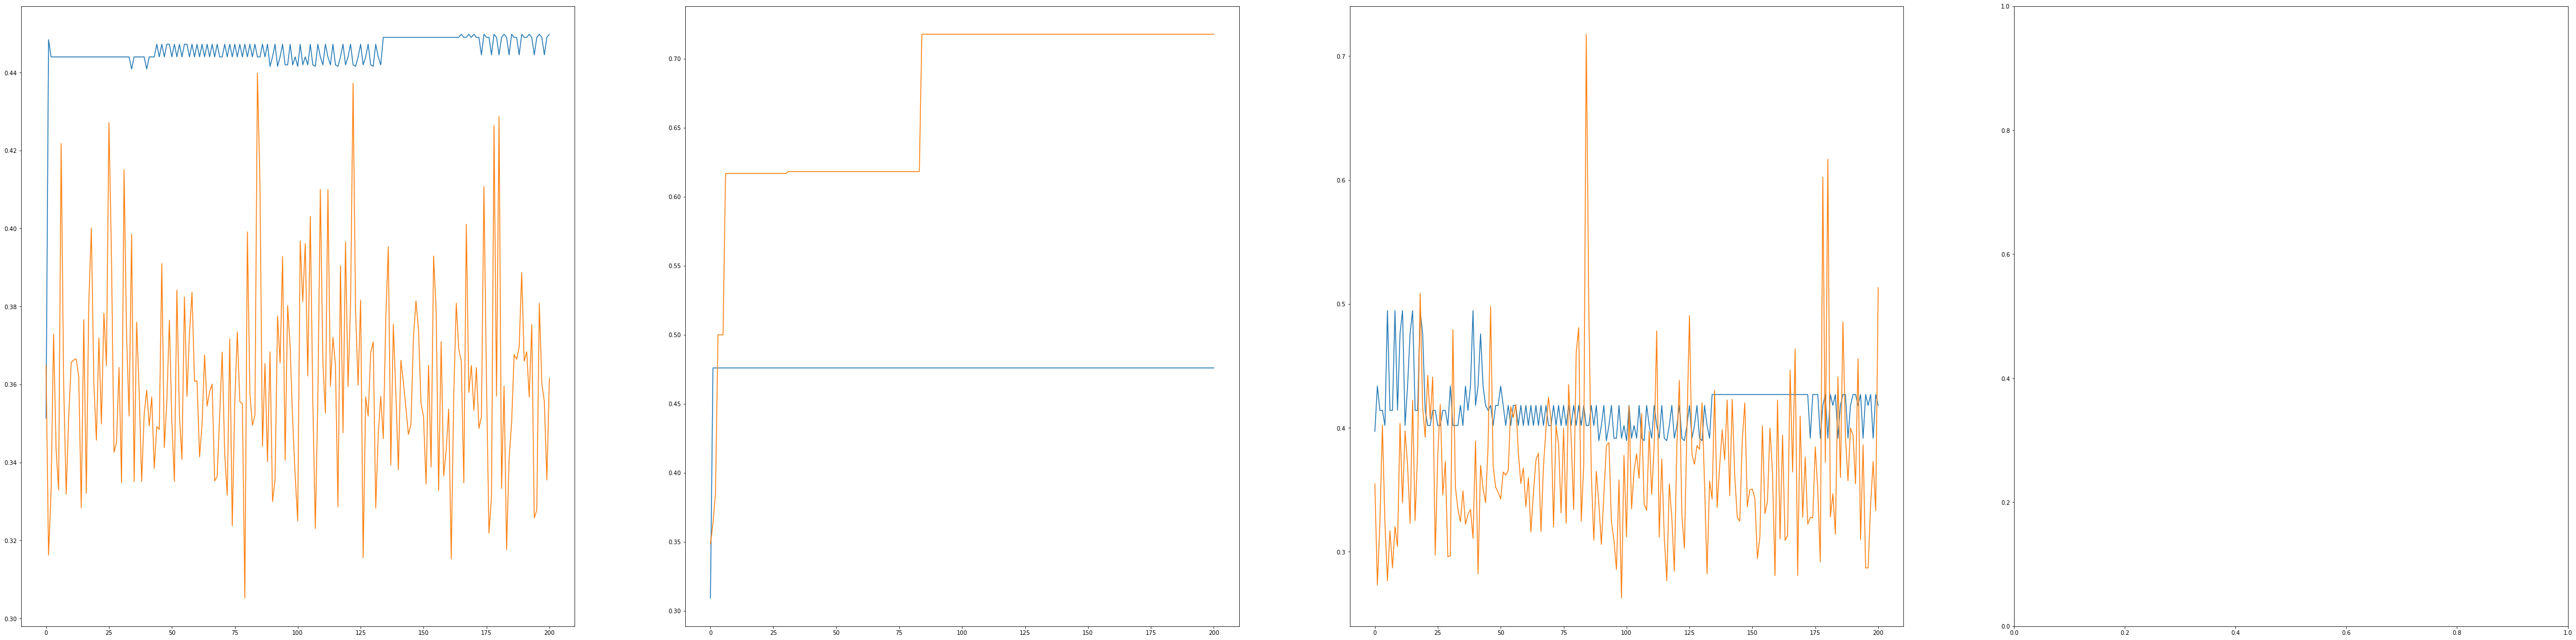

In [34]:
adeptOpt = AdeptOptimizer_Batch(embeddings_pool, brain_rewards, shuffle=True, batch_size=5, alpha=0)
randomOpt = RandomOptimizer_Batch(brain_rewards, 2000, batch_size=5)
analyze_performance_magnitude(adeptOpt, randomOpt, 200, 'random decay')

Initial Images #:  [272 179 919 732 637 648 247 970 854 830 714 797 113 457 559 246 802 559
 129 283 111 229  67 728 106 415 834 995 283 873 728   3 230 767 443 334
 429 317 360 198 634 202 188 483 356 571 385  70 640 400]
[[272 179 919 732 637]
 [648 247 970 854 830]
 [714 797 113 457 559]
 ...
 [371 390 612 502 509]
 [371 390 612 502 509]
 [390 730 612 502 509]]


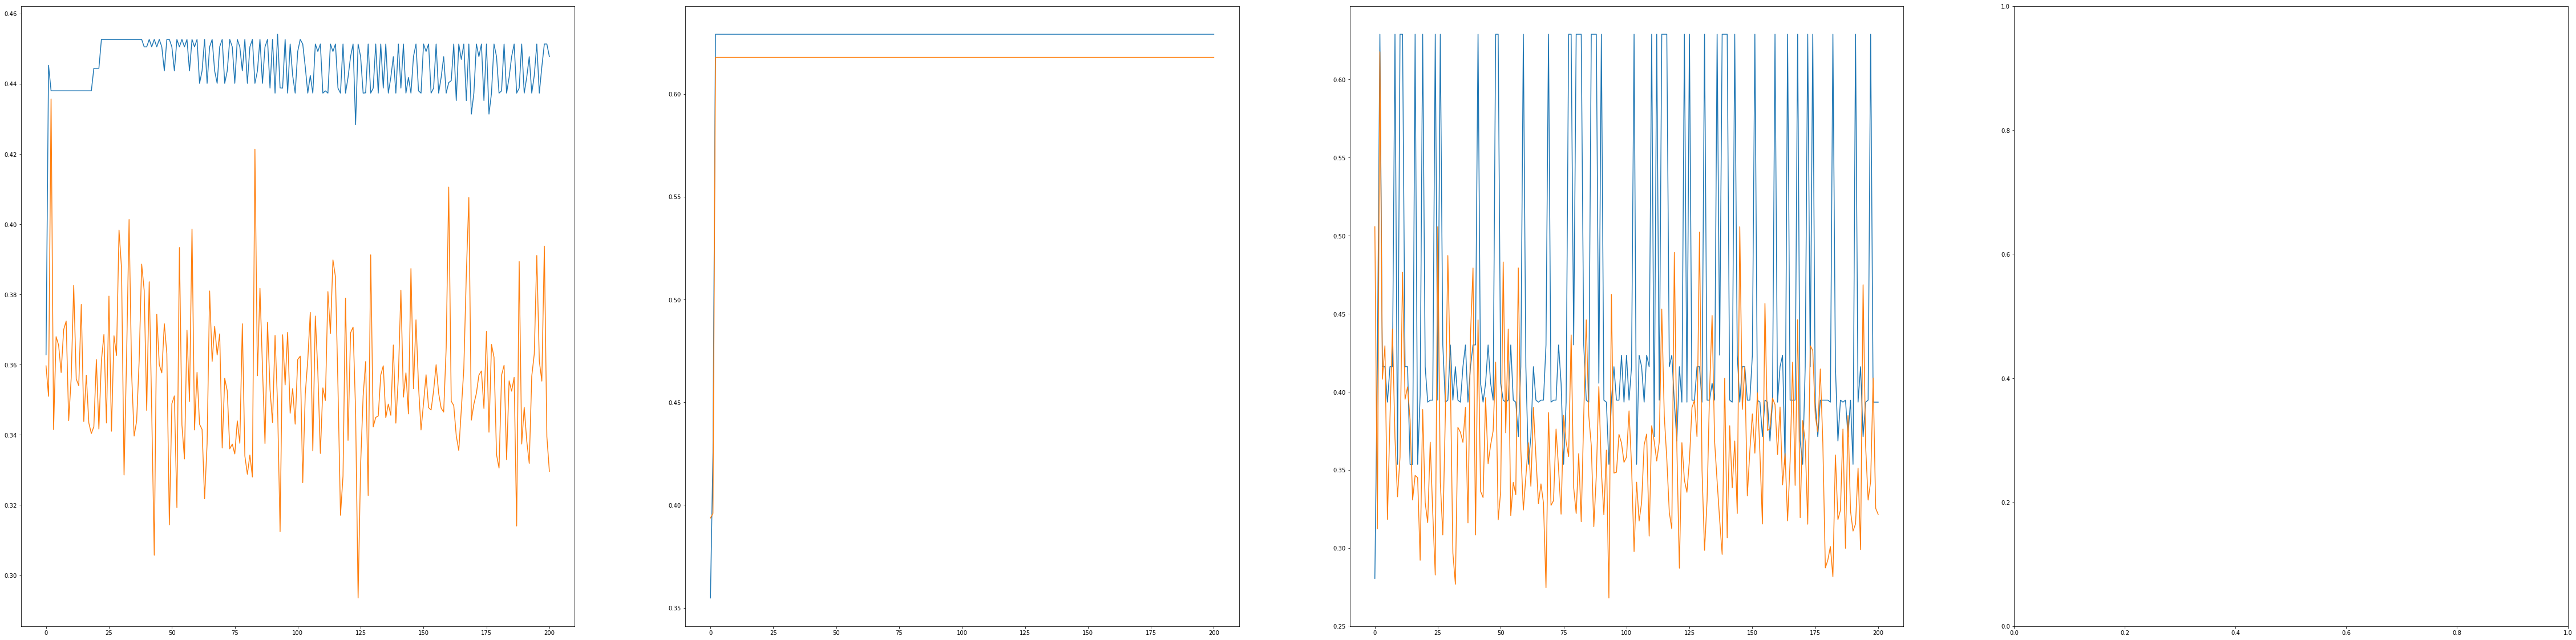

In [29]:
adeptOpt = AdeptOptimizer_Batch(embeddings_pool, brain_rewards, shuffle=True, batch_size=10, alpha=0)
randomOpt = RandomOptimizer_Batch(brain_rewards, 1000, batch_size=10)
analyze_performance_magnitude(adeptOpt, randomOpt, 100, 'softmax')


In [22]:
# Ground Truth based on brain activations
activations = brain_rewards[:1000]
mean_activations = np.mean(np.array(activations), axis=1)
top_candidates = np.argsort(mean_activations)[-50:]
print(top_candidates)

[517 507 519 932 356 947 345 607 929 321 553  64 133 120 646 159  77  33
 955 971 339 962  32 560 679  63 307 902 447 125 826 654 808 379 428 425
 925 879  17  57 641 750 495 529 429 536 648 244 569 509]


In [31]:
class AdeptOptimizer_Random_Batch:
    def __init__(self, embeddings_pool, brain_rewards, N_init=50, h=200, shuffle=True, batch_size=50, 
                 noise_scale=0.01, decay=0.5, alpha=0):
        self.num_stimuli = embeddings_pool.shape[0]
        self.embed_dim = embeddings_pool.shape[1]
        self.kernel_mat = rbf_kernel(embeddings_pool, gamma=1/(h*h))
        self.reward_diffs = np.zeros((N_init, N_init))
        self.batch_size = batch_size
        self.decay = decay
        self.alpha = alpha
        # All rewards with noises are precomputed, which hopefully doesn't affect the effect of simulation
        # with decay update in 'propose_batch'
        self.brain_rewards_noisy = brain_rewards + np.random.normal(0.0, brain_rewards*0.1, brain_rewards.shape)
        # without any update
        self.brain_rewards_noisy_copy = np.copy(self.brain_rewards_noisy)
        
        
        if shuffle:
            self.chosen_indices = np.random.choice(self.num_stimuli, N_init)
            self.reward_diffs += euclidean_distances(np.take(self.brain_rewards_noisy, self.chosen_indices, axis=0))
        else:    
            self.reward_diffs += euclidean_distances(self.brain_rewards_noisy[:N_init])
            self.chosen_indices = np.arange(N_init)
        self.init_indices = self.chosen_indices
        self.reward_norms = np.linalg.norm(self.brain_rewards_noisy, axis=1)
        
        init_rewards = np.take(self.brain_rewards_noisy, self.init_indices, axis=0)
        init_mean_rewards = np.mean(np.array(init_rewards), axis=1)
        
        self.best_index = np.argmax(init_mean_rewards)
        self.best_reward = self.brain_rewards_noisy[self.best_index]
        print("Initial Images #: ", self.chosen_indices)
        
    #def add_noise(self, x, scale=0.01):
    #    return x + np.random.normal(0.0, scale, x.shape)
    
    def propose_batch(self):
        #if len(self.chosen_indices) >= len(images_pool):
        #    print("All images have been proposed.")
        #    return
        num_seen_stimuli = len(np.unique(self.chosen_indices))
        if num_seen_stimuli >= self.num_stimuli:
            print("All images have been proposed at least once!")
            return
        candidates = np.zeros(self.num_stimuli)
        for i in range(self.num_stimuli):
            kernel_embedding = self.kernel_mat[self.chosen_indices][:, i] / np.sum(self.kernel_mat[self.chosen_indices][:, i])
            norm = np.dot(kernel_embedding, np.take(self.reward_norms, self.chosen_indices))
            avg_dist = np.mean(np.matmul(kernel_embedding.T, self.reward_diffs))
            candidates[i] = norm + self.alpha * avg_dist
                
        #dist = candidates / np.sum(candidates)
        dist = np.exp(candidates) / np.sum(np.exp(candidates))
        best_candidates = np.random.choice(np.arange(self.num_stimuli), size=self.batch_size, replace=False, p=dist)
        return best_candidates
    
    def evaluate_and_update_batch(self, best_candidates):
        #dist = euclidean_distances(np.take(self.brain_rewards_noisy_copy, self.chosen_indices, axis=0), self.brain_rewards_noisy[best_candidates])
        for i in best_candidates:
            self.brain_rewards_noisy[i] = self.brain_rewards_noisy[i]*self.decay
        self.reward_diffs = np.hstack((self.reward_diffs, euclidean_distances(np.take(self.brain_rewards_noisy_copy, self.chosen_indices, axis=0), self.brain_rewards_noisy_copy[best_candidates])))
        self.chosen_indices = np.concatenate((self.chosen_indices, best_candidates))
        self.reward_diffs = np.vstack((self.reward_diffs, np.transpose(euclidean_distances(np.take(self.brain_rewards_noisy_copy, self.chosen_indices, axis=0), self.brain_rewards_noisy_copy[best_candidates]))))
        
        index = np.argmax(np.mean(np.array(self.brain_rewards_noisy_copy[best_candidates]), axis=1))
        best_reward = self.brain_rewards_noisy_copy[best_candidates[index]]
        if np.mean(np.array(best_reward)) > np.mean(np.array(self.best_reward)):
            self.best_index = best_candidates[index]
            self.best_reward = best_reward
            
        return np.take(self.brain_rewards_noisy_copy, best_candidates, axis=0)
    
    def propose_one(self, candidates, mode):
        candidate = np.random.choice(candidates)
        if mode == 'naive random':
            candidate_rewards = np.take(self.brain_rewards_noisy_copy, candidates, axis=0)
            distribution = np.mean(np.array(candidate_rewards), axis=1)
            distribution = distribution / np.sum(distribution)
            candidate = np.random.choice(candidates, p=distribution)
        elif mode == 'random decay':
            candidate_rewards = np.take(self.brain_rewards_noisy, candidates, axis=0)
            distribution = np.mean(np.array(candidate_rewards), axis=1)
            distribution = distribution / np.sum(distribution)
            candidate = np.random.choice(candidates, p=distribution)
        elif mode == 'softmax':
            candidate_rewards = np.take(self.brain_rewards_noisy_copy, candidates, axis=0)
            distribution = np.mean(np.array(candidate_rewards), axis=1)
            distribution = np.exp(distribution) / np.sum(np.exp(distribution))
            candidate = np.random.choice(candidates, p=distribution)
        return candidate, self.brain_rewards_noisy_copy[candidate]
    
    

In [ ]:
adeptOpt = AdeptOptimizer_Random_Batch(embeddings_pool, brain_rewards, shuffle=True, batch_size=20, alpha=0)
randomOpt = RandomOptimizer_Batch(brain_rewards, 10000, batch_size=20)
analyze_performance_magnitude(adeptOpt, randomOpt, 500, 'naive random')